In [1]:
import laspy as lp
import numpy as np
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path

from optical_group_5.points2dem import dem, classes

In [2]:
DATA = Path("../data")
f = lp.read(DATA / "2024_Golm_AEO_trees.laz")
ground = lp.read(DATA / "Ground points.las")
gdf = gpd.read_file(DATA / "CampusGolm_Clipper.gpkg")

<Axes: >

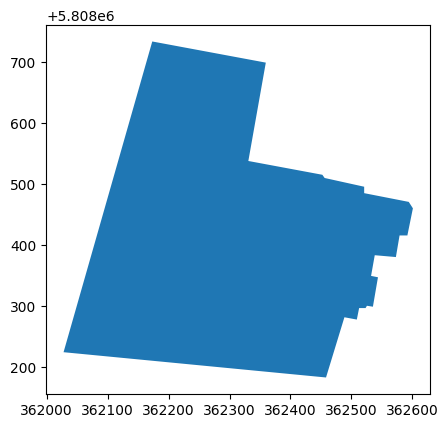

In [3]:
gdf.plot()

## Gen data

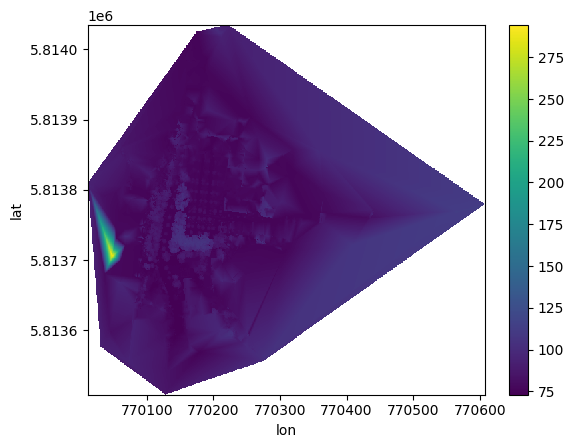

In [4]:
dsm = dem(f, interp=True)
dsm.plot()

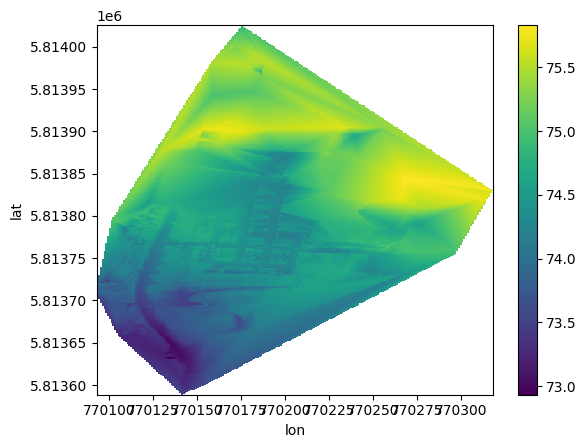

In [5]:
dtm = dem(ground, interp=True)
dtm.plot()

In [6]:
dsm = dsm.rio.write_crs(f.header.parse_crs())
dsm = dsm.rio.set_spatial_dims(x_dim="lon", y_dim="lat")

dtm = dtm.rio.write_crs(ground.header.parse_crs())
dtm = dtm.rio.set_spatial_dims(x_dim="lon", y_dim="lat")

dsm = dsm.rio.reproject(gdf.crs)
dsm = dsm.where(dsm < 1e100)
dsm = dsm.rio.clip(gdf.geometry)
dsm = dsm.where(dsm < 1e100)

dtm = dtm.rio.reproject(gdf.crs)
dtm = dtm.where(dtm < 1e100)
dtm = dtm.rio.clip(gdf.geometry)
dtm = dtm.where(dtm < 1e100)

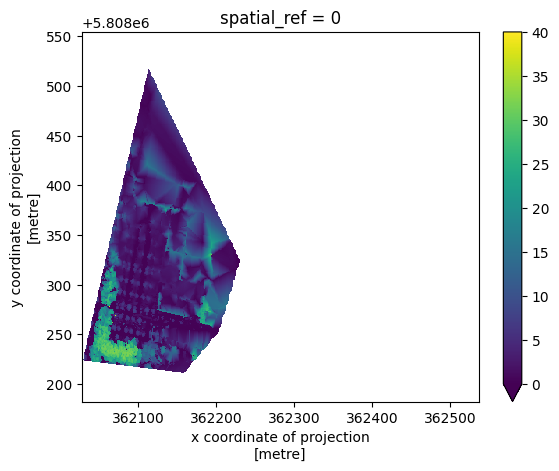

In [7]:
rh = ((dsm - dtm.interp_like(dsm))+0.3)
rh.plot.imshow(vmin=0, vmax=40)

In [8]:
# Align the rasters
dtm = dtm.interp_like(dsm)
rh = rh.interp_like(dsm)

In [9]:
# Add metdata to the rasters
dsm.name = "DSM"
dsm.attrs["units"] = "m"
dsm.attrs["long_name"] = "Digital Surface Model"

dtm.name = "DTM"
dtm.attrs["units"] = "m"
dtm.attrs["long_name"] = "Digital Terrain Model"

rh.name = "Relative_Height"
rh.attrs["units"] = "m"
rh.attrs["long_name"] = "Relative Height"

ds = xr.Dataset(
    {
        "dsm": dsm,
        "dtm": dtm,
        "rh": rh,
    }
)
ds

<xarray.Dataset> Size: 5MB
Dimensions:      (x: 509, y: 372)
Coordinates:
  * x            (x) float64 4kB 3.62e+05 3.62e+05 ... 3.625e+05 3.625e+05
  * y            (y) float64 3kB 5.809e+06 5.809e+06 ... 5.808e+06 5.808e+06
    spatial_ref  int64 8B 0
Data variables:
    dsm          (y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan nan
    dtm          (y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan nan
    rh           (y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan nan

In [10]:
rh.to_netcdf(DATA / "relative_height_latest.nc")

In [11]:
def plot_single_categorical_height(ax, height, height_min, height_max):
    # Create a mask for the specified class and the height range
    mask =(height >= height_min) & (height <= height_max)

    # Apply the mask to the height data
    height_masked = xr.where(mask, height, np.nan)

    # Plot the masked height data
    im = height_masked.plot.imshow(ax=ax, cmap='seismic')

    return im

In [12]:
from ipywidgets import interact

# Define a dictionary for the class names and values
# Define a function for updating the plot
def update_plot(height_min=0, height_max=50):

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))
    im = plot_single_categorical_height(ax, ds.rh, round(height_min, 2), round(height_max, 2))

    # Find the class name corresponding to the class value
    #configure the plot
    ax.set_title(f"Relative height between {round(height_min, 2)} and {round(height_max, 2)} meters")
    ax.set_ylabel("Latitude (y of EPSG:32633) [m]")
    ax.set_xlabel("Longitude (x of EPSG:32633) [m]")
    plt.show()

# Create interactive widgets for class and height
_ = interact(update_plot, height_min=(0, 37, 0.1), height_max=(1, 37, 0.1))

interactive(children=(FloatSlider(value=0.0, description='height_min', max=37.0), FloatSlider(value=37.0, desc…